# Load Data dan generate dataset

In [1]:
# Load the .mat file
import scipy.io
import matplotlib.pyplot as plt

mat_file_path = 'gyro_acc_ppg/Subject_1.mat'
mat_data = scipy.io.loadmat(mat_file_path)

# Access the signals you want to plot
sigPPG = mat_data['sigPPG']
sigAcc = mat_data['sigAcc']
sigGyro = mat_data['sigGyro']
sigECG = mat_data['bpmECG']

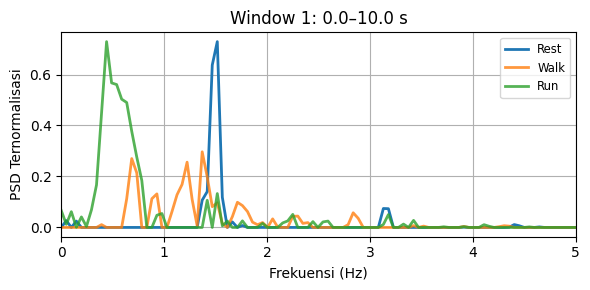

In [3]:
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.fft import fft
import matplotlib.pyplot as plt

# --- ASSUME: sigPPG and sigAcc are already loaded and downsampled to 50 Hz ---
# And in variables sigPPG (3, N), sigAcc (3, N)

# 1) TRANSPOSE & CLEAN
ppg = sigPPG.T   # shape (N, 3)
acc = sigGyro.T   # shape (N, 3)

mask = (~np.isnan(ppg).any(axis=1)) & (~np.isnan(acc).any(axis=1))
ppg, acc = ppg[mask], acc[mask]

# 2) SLICE INTO REST / WALK / RUN
fs = 50
n_rest_end = 60 * fs     # 0–60 s
n_walk_start = 61 * fs    # 60–180 s
n_walk_end = 180 * fs     # 120–240 s
n_run_start = 181 * fs    # 180–300 s
n_run_end  = 360 * fs    # 180–300 s

ppg_rest = ppg[:n_rest_end];                 acc_rest = acc[:n_rest_end]
ppg_walk = ppg[n_walk_start:n_walk_end];    acc_walk = acc[n_walk_start:n_walk_end]
ppg_run  = ppg[n_run_start:n_run_end]; acc_run  = acc[n_run_start:n_run_end]

# 3) WINDOWING PARAMETERS
win_sec   = 10
shift_sec = 1
win_samp  = int(win_sec * fs)
shift_samp= int(shift_sec * fs)
nfft      = 1024

# compute how many windows fit in each segment
n_win_rest = (len(ppg_rest) - win_samp)//shift_samp + 1
n_win_walk = (len(ppg_walk) - win_samp)//shift_samp + 1
n_win_run  = (len(ppg_run)  - win_samp)//shift_samp + 1
num_plot   = min(n_win_rest, n_win_walk, n_win_run, 1)

# frequency axis
freqs = np.linspace(0, fs/2, nfft//2)

# bandpass helper
def bandpass(x):
    b, a = butter(4, [0.4/(fs/2), 4.0/(fs/2)], btype='band')
    return filtfilt(b, a, x, axis=0)


def compute_pc(ppg_win, acc_win):
    # 1) Band‐pass filter (0.4–4 Hz)
    P = bandpass(ppg_win)    # shape (win_len, n_ppg_axes)
    G = bandpass(acc_win)    # shape (win_len, n_acc_axes)

    # 2) Composite PPG in time domain
    #   a) z-score each channel
    # Pz = (P - P.mean(axis=0)) / (P.std(axis=0) + 1e-8)
    #   b) average channels
    p  = P.mean(1)
    #   c) final z-score the composite
    # p  = (p - p.mean()) / (p.std() + 1e-8)

    # 3) FFT of PPG → normalize to [0,1]
    PS = np.abs(fft(p, nfft))[:nfft//2]
    PS = (PS - PS.min()) / (PS.max() - PS.min() + 1e-12)

    # 4) FFT each ACC axis → normalize each → then average
    PG_axes = []
    for ax in range(G.shape[1]):
        g_ax = G[:, ax]
        mag  = np.abs(fft(g_ax, nfft))[:nfft//2]

        PG_axes.append(mag)
    PG = np.mean(PG_axes, axis=0)
    PG  = (PG - PG.min()) / (PG.max() - PG.min() + 1e-12)
    # 5) Subtract motion spectrum and floor at zero
    PC = np.clip(PS - PG, 0, None)
    return PC

# def compute_pc(ppg_win, acc_win):
#     # 1) Band‐pass filter (0.4–4 Hz)
#     # P = bandpass(ppg_win)    # shape (win_len, n_ppg_axes)
#     G = bandpass(acc_win)    # shape (win_len, n_acc_axes)

#     # 2) Composite PPG in time domain
#     #   a) z-score each channel
#     # Pz = (P - P.mean(axis=0)) / (P.std(axis=0) + 1e-8)
#     #   b) average channels
#     p  = ppg_win.mean(1)

#     # 3) FFT of PPG → normalize to [0,1]
#     PS = np.abs(fft(p, nfft))[:nfft//2]
#     PS = (PS - PS.min()) / (PS.max() - PS.min() + 1e-12)

#     # 4) FFT each ACC axis → normalize each → then average
#     PG_axes = []
#     for ax in range(G.shape[1]):
#         g_ax = G[:, ax]
#         mag  = np.abs(fft(g_ax, nfft))[:nfft//2]

#         PG_axes.append(mag)
#     PG = np.mean(PG_axes, axis=0)
#     PG  = (PG - PG.min()) / (PG.max() - PG.min() + 1e-12)
#     # 5) Subtract motion spectrum and floor at zero
#     PC = np.clip(PS - PG, 0, None)
#     return PS

# 4) PLOT ONE FIGURE PER WINDOW with all three curves
for i in range(num_plot):
    start = i * shift_samp
    end   = start + win_samp

    pc_rest = compute_pc(ppg_rest[start:end], acc_rest[start:end])
    pc_walk = compute_pc(ppg_walk[start:end], acc_walk[start:end])
    pc_run  = compute_pc(ppg_run[start:end],  acc_run[start:end])

    plt.figure(figsize=(6, 3))
    plt.plot(freqs, pc_rest, label='Rest', linewidth=2)
    plt.plot(freqs, pc_walk, label='Walk', linewidth=2, alpha=0.8)
    plt.plot(freqs, pc_run,  label='Run',  linewidth=2, alpha=0.8)
    plt.xlim(0, 5)
    plt.xlabel('Frekuensi (Hz)')
    plt.ylabel('PSD Ternormalisasi')
    t0 = start / fs
    t1 = (end - 1) / fs
    plt.title(f'Window {i+1}: {t0:.1f}–{t1:.1f} s')
    plt.legend(fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [7]:
import os
import numpy as np
import scipy.io
from scipy.signal import butter, filtfilt
from scipy.fft import fft
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset

# 1) GLOBAL PARAMETERS
fs = 50
nfft = 1024 #0-3 hz 31 bins
win_sec, shift_sec = 10, 1
win_samp   = int(win_sec  * fs)
shift_samp = int(shift_sec * fs)

# 2) SEGMENT DEFINITIONS (start_sec, end_sec, label)
# 0=Rest, 1=Walk, 2=Run
segments = [
    (0,   60,  0),  # rest
    (60,  180, 1),  # walk
    (180, 360, 2),  # run
    (360, 480, 1),  # walk
    (480, 660, 2),  # run
    (660, 780, 1),  # walk
    (780, 840, 0),  # rest
]

# frequency axis and index cutoff for ≤3 Hz
freqs = np.linspace(0, fs/2, nfft//2)
idx_max = np.searchsorted(freqs, 4, side='right') + 1  #edit


# 4) DATASET GENERATION
def generate_dataset(base_folder, n_subjects=24, augment_rest_class=True, rest_label=0, noise_std=0.1):
    X, y = [], []
    for subj in range(1, n_subjects + 1):
        mat = scipy.io.loadmat(os.path.join(base_folder, f'Subject_{subj}.mat'))
        ppg  = mat['sigPPG'].T   # (N,3) @50Hz
        gyro = mat['sigGyro'].T  # (N,3) @50Hz

        # drop NaNs
        mask = (~np.isnan(ppg).any(1)) & (~np.isnan(gyro).any(1))
        ppg, gyro = ppg[mask], gyro[mask]

        for start_sec, end_sec, label in segments:
            s_idx = int(start_sec * fs)
            e_idx = int(end_sec   * fs)
            seg_ppg  = ppg[s_idx:e_idx]
            seg_gyro = gyro[s_idx:e_idx]
            n_win = (len(seg_ppg) - win_samp) // shift_samp + 1

            for i in range(n_win):
                ws = i * shift_samp
                we = ws + win_samp

                # Original segment
                pc = compute_pc(seg_ppg[ws:we], seg_gyro[ws:we])
                X.append(pc[:idx_max])
                y.append(label)

                # Augmentation only for rest class
                if augment_rest_class and label == rest_label:
                    noisy_ppg = seg_ppg[ws:we] + np.random.normal(0, noise_std, seg_ppg[ws:we].shape)
                    pc_aug = compute_pc(noisy_ppg, seg_gyro[ws:we])
                    X.append(pc_aug[:idx_max])
                    y.append(label)

    X = np.vstack(X)
    y = np.array(y)
    return X, y


# def generate_dataset(base_folder, n_subjects=24):
#     X, y = [], []
#     for subj in range(1, n_subjects+1):
#         mat = scipy.io.loadmat(os.path.join(base_folder, f'Subject_{subj}.mat'))
#         ppg  = mat['sigPPG'].T   # (N,3) @50Hz
#         gyro = mat['sigGyro'].T  # (N,3) @50Hz
#         # drop NaNs
#         mask = (~np.isnan(ppg).any(1)) & (~np.isnan(gyro).any(1))
#         ppg, gyro = ppg[mask], gyro[mask]
#         # iterate segments
#         for start_sec, end_sec, label in segments:
#             s_idx = int(start_sec * fs)
#             e_idx = int(end_sec   * fs)
#             seg_ppg  = ppg[s_idx:e_idx]
#             seg_gyro = gyro[s_idx:e_idx]
#             n_win = (len(seg_ppg) - win_samp) // shift_samp + 1
#             for i in range(n_win):
#                 ws = i * shift_samp
#                 we = ws + win_samp
#                 pc = compute_pc(seg_ppg[ws:we], seg_gyro[ws:we])
#                 # keep only ≤3 Hz bins
#                 X.append(pc[:idx_max])
#                 y.append(label)
#     X = np.vstack(X)
#     y = np.array(y)
#     return X, y

# 5) SPLIT 80/20
base_folder = 'gyro_acc_ppg'
X, y = generate_dataset(base_folder, n_subjects=24, augment_rest_class=True, rest_label=0, noise_std=0.1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 6) PYTORCH DATASET
class PCGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = PCGDataset(X_train, y_train)
test_dataset  = PCGDataset(X_test,  y_test)

print("Train samples:", len(train_dataset))
print("Test  samples:", len(test_dataset))

Train samples: 14767
Test  samples: 6329


In [8]:
idx_max # add 1 supaya 32 bit, mudah transfernya

np.int64(83)

In [9]:
import numpy as np

# Print total dataset per class for train and test sets
print("Train set class counts:")
for cls in np.unique(y_train):
    count = np.sum(y_train == cls)
    print(f"  Class {cls}: {count}")

print("\nTest set class counts:")
for cls in np.unique(y_test):
    count = np.sum(y_test == cls)
    print(f"  Class {cls}: {count}")

Train set class counts:
  Class 0: 3430
  Class 1: 5603
  Class 2: 5734

Test set class counts:
  Class 0: 1466
  Class 1: 2389
  Class 2: 2474


# RATE CODING TRAINING

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import snntorch as snn
from snntorch import spikegen, surrogate, functional
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

# Assume `train_dataset` and `test_dataset` are defined, and `device` is set
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=256, shuffle=False)

# 1) SNN MODEL DEFINITION WITH MULTIPLE HIDDEN LAYERS
class SNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 64], n_classes=3, beta=0.99):
        super().__init__()
        # Build lists of fully-connected and LIF layers
        dims = [input_dim] + hidden_dims + [n_classes]
        self.fc_layers = nn.ModuleList()
        self.lif_layers = nn.ModuleList()
        for i in range(len(dims) - 1):
            self.fc_layers.append(nn.Linear(dims[i], dims[i+1], bias=False))
            # Learnable beta and threshold for each layer
            # self.lif_layers.append(snn.Leaky(beta=beta, learn_beta=True, learn_threshold=True))
            self.lif_layers.append(snn.Leaky(beta=beta, learn_beta=True, learn_threshold=True, inhibition=False))

    def forward(self, x):
        # x shape: (num_steps, batch, features)
        seq_len, batch_size, _ = x.size()
        # Initialize membrane potentials for each layer
        mem = [torch.zeros(batch_size, layer.out_features, device=x.device)
               for layer in self.fc_layers]

        spk_rec = []
        for step in range(seq_len):
            cur = x[step]
            # Propagate through each fc + lif layer
            for idx, (fc, lif) in enumerate(zip(self.fc_layers, self.lif_layers)):
                cur = fc(cur)
                spk, mem[idx] = lif(cur, mem[idx])
                cur = spk
            spk_rec.append(cur)

        # stack spikes: (num_steps, batch, n_classes)
        return torch.stack(spk_rec), mem[-1]

# Instantiate
input_dim = train_dataset.X.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelr = SNNClassifier(input_dim, hidden_dims=[64], n_classes=3).to(device)

# 2) LOSS & OPTIMIZER
# criterion = nn.CrossEntropyLoss()

# criterion = snn.functional.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)
criterion = snn.functional.ce_count_loss()
optimizer = optim.Adam(modelr.parameters(), lr=1e-3)

# 3) TRAINING LOOP WITH RATE CODING & PROGRESS BAR
num_steps = 20  # number of time‐steps for rate encoding
n_epochs  = 50
history_rate = {'loss': [], 'accuracy': []}

for epoch in range(1, n_epochs + 1):
    modelr.train()
    total_loss = 0.0
    total_accu = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{n_epochs}", leave=False)
    for X_batch, y_batch in pbar:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # rate‐encode inputs to spikes
        spk_in = spikegen.rate(X_batch, num_steps=num_steps)

        optimizer.zero_grad()
        spk_out, _ = modelr(spk_in)
        # spk_out shape: (T, B, C)
        loss = criterion(spk_out, y_batch)
        loss.backward()
        optimizer.step()

        spike_counts = spk_out.sum(dim=0)  # sum across time steps
        preds = spike_counts.argmax(dim=1)

        correct = (preds == y_batch).sum().item()
        accu = correct / y_batch.size(0)
        pbar.set_postfix({"batch_loss": f"{loss.item():.4f}", "batch_acc": f"{accu:.4f}"})

        total_loss += loss.item() * X_batch.size(0)
        total_accu += accu * X_batch.size(0)
        # accu = functional.acc.accuracy_temporal(spk_out, y_batch)
        # pbar.set_postfix({"batch_loss": f"{loss.item():.4f}", "batch_acc": f"{accu.item():.4f}"})

        # total_loss += loss.item() * X_batch.size(0)
        # total_accu += accu.item() * X_batch.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    avg_acc = total_accu / len(train_loader.dataset)
    history_rate['loss'].append(avg_loss)
    history_rate['accuracy'].append(avg_acc)

    print(f"Epoch {epoch}/{n_epochs}, Average Loss: {avg_loss:.4f}, Accuracy : {avg_acc:.4f}")

Epoch 1/50, Average Loss: 0.8520, Accuracy : 0.6267


Epoch 2/50, Average Loss: 0.6955, Accuracy : 0.7274


Epoch 3/50, Average Loss: 0.6367, Accuracy : 0.7516


Epoch 4/50, Average Loss: 0.5994, Accuracy : 0.7617


Epoch 5/50, Average Loss: 0.5712, Accuracy : 0.7686


Epoch 6/50, Average Loss: 0.5487, Accuracy : 0.7812


Epoch 7/50, Average Loss: 0.5322, Accuracy : 0.7871


Epoch 8/50, Average Loss: 0.5186, Accuracy : 0.7916


Epoch 9/50, Average Loss: 0.5046, Accuracy : 0.7997


Epoch 10/50, Average Loss: 0.4971, Accuracy : 0.8021


Epoch 11/50, Average Loss: 0.4898, Accuracy : 0.8056


Epoch 12/50, Average Loss: 0.4758, Accuracy : 0.8104


Epoch 13/50, Average Loss: 0.4713, Accuracy : 0.8098


Epoch 14/50, Average Loss: 0.4551, Accuracy : 0.8140


Epoch 15/50, Average Loss: 0.4568, Accuracy : 0.8172


Epoch 16/50:  69%|██████▉   | 40/58 [00:01<00:00, 31.69it/s, batch_loss=0.4001, batch_acc=0.8281]

Epoch 16/50, Average Loss: 0.4484, Accuracy : 0.8176


Epoch 17/50, Average Loss: 0.4381, Accuracy : 0.8223


Epoch 18/50, Average Loss: 0.4346, Accuracy : 0.8254


Epoch 19/50, Average Loss: 0.4275, Accuracy : 0.8304


Epoch 20/50, Average Loss: 0.4185, Accuracy : 0.8321


Epoch 21/50, Average Loss: 0.4186, Accuracy : 0.8306


Epoch 22/50, Average Loss: 0.4105, Accuracy : 0.8373


Epoch 23/50, Average Loss: 0.4088, Accuracy : 0.8317


Epoch 24/50, Average Loss: 0.4064, Accuracy : 0.8355


Epoch 25/50, Average Loss: 0.4026, Accuracy : 0.8361


Epoch 26/50, Average Loss: 0.3949, Accuracy : 0.8387


Epoch 27/50, Average Loss: 0.3980, Accuracy : 0.8366


Epoch 28/50, Average Loss: 0.3930, Accuracy : 0.8401


Epoch 29/50, Average Loss: 0.3873, Accuracy : 0.8406


Epoch 30/50, Average Loss: 0.3855, Accuracy : 0.8445


Epoch 31/50, Average Loss: 0.3940, Accuracy : 0.8395


Epoch 32/50, Average Loss: 0.3795, Accuracy : 0.8469


Epoch 33/50, Average Loss: 0.3765, Accuracy : 0.8478


Epoch 34/50, Average Loss: 0.3746, Accuracy : 0.8501


Epoch 35/50, Average Loss: 0.3794, Accuracy : 0.8430


Epoch 36/50, Average Loss: 0.3706, Accuracy : 0.8476


Epoch 37/50, Average Loss: 0.3747, Accuracy : 0.8450


Epoch 38/50, Average Loss: 0.3663, Accuracy : 0.8518


Epoch 39/50, Average Loss: 0.3713, Accuracy : 0.8482


Epoch 40/50, Average Loss: 0.3627, Accuracy : 0.8498


Epoch 41/50, Average Loss: 0.3630, Accuracy : 0.8500


Epoch 42/50, Average Loss: 0.3682, Accuracy : 0.8486


Epoch 43/50, Average Loss: 0.3607, Accuracy : 0.8507


Epoch 44/50, Average Loss: 0.3606, Accuracy : 0.8532


Epoch 45/50, Average Loss: 0.3566, Accuracy : 0.8572


Epoch 46/50, Average Loss: 0.3557, Accuracy : 0.8573


Epoch 47/50, Average Loss: 0.3548, Accuracy : 0.8581


Epoch 48/50, Average Loss: 0.3547, Accuracy : 0.8570


Epoch 49/50, Average Loss: 0.3549, Accuracy : 0.8521


Epoch 50/50, Average Loss: 0.3523, Accuracy : 0.8597


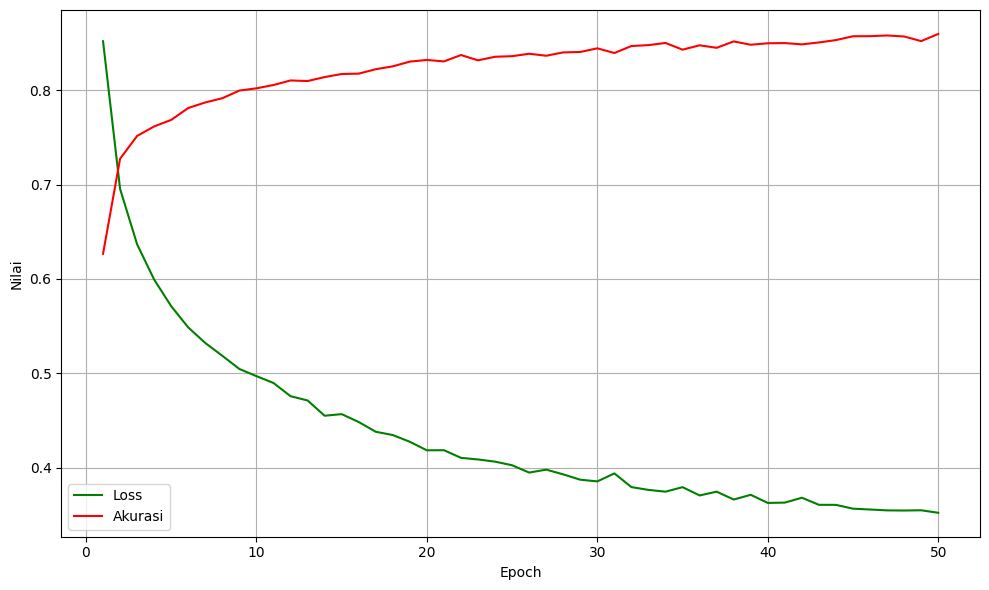

In [11]:
import matplotlib.pyplot as plt

# Extract loss and accuracy from history_rate
loss = history_rate['loss']
accuracy = history_rate['accuracy']
epochs = range(1, len(loss) + 1)

# Plot loss and accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Loss', color='green')
plt.plot(epochs, accuracy, label='Akurasi', color='red')
plt.xlabel('Epoch')
plt.ylabel('Nilai')
# plt.title('Epoch vs Loss and Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

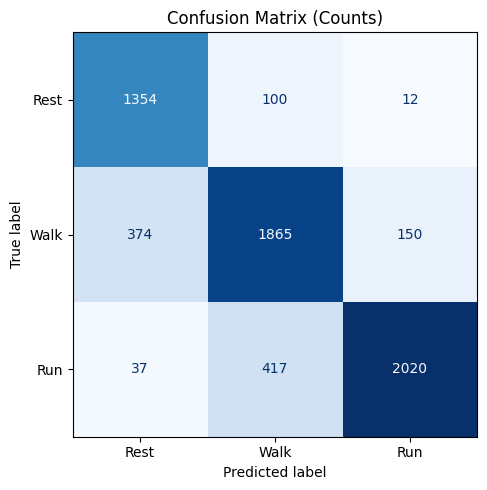

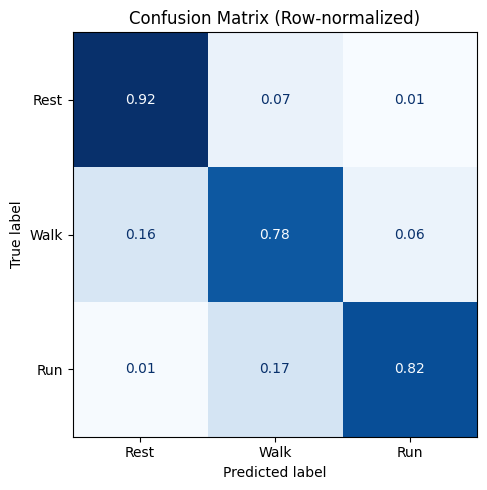

Test accuracy: 82.8%


In [12]:
# 5) Evaluation & confusion matrix
modelr.eval()
all_predsr = []
all_labelsr= []
# Assume `num_steps` is defined (should be the same as training)
# num_steps = 50 # Define num_steps if not already in scope from training

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # --- FIX: Encode X_batch into spikes before passing to the SNN model ---
        # Use the same encoding method and num_steps as used in training
        spk_in = spikegen.rate(X_batch, num_steps=num_steps)

        logits, _ = modelr(spk_in) # The model returns spike recordings and final membrane potential
        # Sum spikes over the time dimension to get the total count per class for prediction
        out_sum = logits.sum(dim=0) # Shape becomes (batch, n_classes)

        preds   = out_sum.argmax(dim=1).cpu().numpy()
        all_predsr.extend(preds)
        all_labelsr.extend(y_batch.cpu().numpy()) # Move y_batch to CPU before converting to numpy

classes = ['Rest','Walk','Run']

# Raw counts
fig, ax = plt.subplots(figsize=(5,5))
ConfusionMatrixDisplay.from_predictions(
    all_labelsr, all_predsr,
    display_labels=classes,
    normalize=None,
    cmap=plt.cm.Blues,
    ax=ax,
    colorbar=False
)
ax.set_title('Confusion Matrix (Counts)')
plt.tight_layout()
plt.show()

# Row-normalized → percentages
fig, ax = plt.subplots(figsize=(5,5))
ConfusionMatrixDisplay.from_predictions(
    all_labelsr, all_predsr,
    display_labels=classes,
    normalize='true',      # normalize over true labels → rows sum to 1
    cmap=plt.cm.Blues,
    ax=ax,
    values_format='.2f',   # shows numbers between 0 and 1
    colorbar=False,
)
ax.set_title('Confusion Matrix (Row-normalized)')
plt.tight_layout()
plt.show()

# 6) Compute accuracy
accuracy = np.mean(np.array(all_predsr) == np.array(all_labelsr))
print(f"Test accuracy: {accuracy*100:.1f}%")

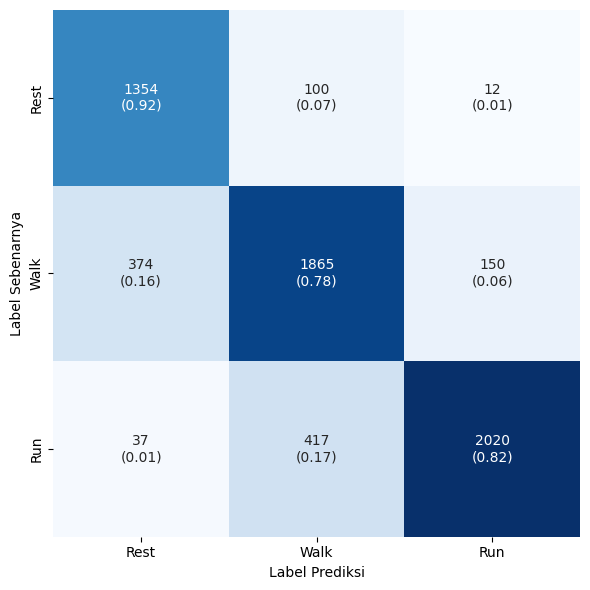

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(all_labelsr, all_predsr)
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# Combine counts and normalized values in a single string matrix
annot = np.empty_like(cm).astype(str)
n_classes = cm.shape[0]
for i in range(n_classes):
    for j in range(n_classes):
        count = cm[i, j]
        norm = cm_norm[i, j]
        annot[i, j] = f"{count}\n({norm:.2f})"

# Plot using seaborn heatmap
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=annot, fmt="", cmap="Blues", xticklabels=classes, yticklabels=classes, cbar=False, ax=ax)

ax.set_xlabel("Label Prediksi")
ax.set_ylabel("Label Sebenarnya")
ax.set_title("")
plt.tight_layout()
plt.show()

In [20]:
torch.save(modelr.state_dict(), "modelr_trained.pth")
print("Trained modelr saved to modelr_trained.pth")

Trained modelr saved to modelr_trained.pth


Layer 0 vth (threshold): 0.13151846826076508
Layer 0 beta: 1.009442925453186
Layer 1 vth (threshold): 1.2012684345245361
Layer 1 beta: 1.0100401639938354
Saved modelr_vth.npy and modelr_beta.npy


In [24]:
import numpy as np

# Extract weights from each fully connected layer in modelr
weights = [layer.weight.detach().cpu().numpy() for layer in modelr.fc_layers]

# Save all weights to a single .npz file
np.savez('modelr_weights.npz', **{f'fc{i}_weight': w for i, w in enumerate(weights)})

print("Weights from modelr layers saved to modelr_weights.npz")

Weights from modelr layers saved to modelr_weights.npz


# LATENCY CODING TRAINING

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import snntorch as snn
from snntorch import spikegen, surrogate, functional
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

# Assume `train_dataset` and `test_dataset` are defined, and `device` is set
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=256, shuffle=False)

# === SNN MODEL ===
class SNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 32], n_classes=3, beta=0.99):
        super().__init__()
        dims = [input_dim] + hidden_dims + [n_classes]
        self.fc_layers = nn.ModuleList()
        self.lif_layers = nn.ModuleList()
        for i in range(len(dims) - 1):
            self.fc_layers.append(nn.Linear(dims[i], dims[i+1], bias=False))
            # self.lif_layers.append(snn.Leaky(beta=beta, learn_beta=False, learn_threshold=False))
            self.lif_layers.append(snn.Leaky(beta=beta, learn_beta=False, learn_threshold=False))

    def forward(self, x):
        seq_len, batch_size, _ = x.size()
        mem = [torch.zeros(batch_size, layer.out_features, device=x.device)
               for layer in self.fc_layers]

        spk_rec = []
        for step in range(seq_len):
            cur = x[step]
            for idx, (fc, lif) in enumerate(zip(self.fc_layers, self.lif_layers)):
                cur = fc(cur)
                spk, mem[idx] = lif(cur, mem[idx])
                cur = spk
            spk_rec.append(cur)

        return torch.stack(spk_rec), mem[-1]

# === Instantiate Model ===
input_dim = train_dataset.X.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modell = SNNClassifier(input_dim, hidden_dims=[64,32], n_classes=3).to(device)

# === Loss & Optimizer ===
criterion = functional.ce_temporal_loss()
optimizer = optim.Adam(modell.parameters(), lr=1e-3)

# === Training Loop with Latency Coding ===
num_steps = 10
n_epochs  = 50
history_latency = {'loss': [], 'accuracy': []}

for epoch in range(1, n_epochs + 1):
    modell.train()
    total_loss = 0.0
    total_accu = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{n_epochs}", leave=False)

    for X_batch, y_batch in pbar:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Latency encoding: spike time proportional to input strength
        # spk_in = spikegen.latency(X_batch,num_steps=num_steps, normalize=True)
        spk_in = spikegen.latency(X_batch,num_steps=num_steps, normalize=True, clip=False)
        optimizer.zero_grad()
        spk_out, _ = modell(spk_in)

        # spk_out shape: (T, B, C)
        loss = criterion(spk_out, y_batch)
        loss.backward()
        optimizer.step()

        # accu = functional.acc.accuracy_temporal(spk_out, y_batch)
        # pbar.set_postfix({"batch_loss": f"{loss.item():.4f}", "batch_acc": f"{accu.item():.4f}"})
        
        # total_loss += loss.item() * X_batch.size(0)
        # total_accu += accu.item() * X_batch.size(0)
        T, B, C = spk_out.shape
        time_steps = torch.arange(T, device=spk_out.device).view(-1, 1, 1)         # (T, 1, 1)
        spike_times = torch.where(spk_out > 0, time_steps, float('inf'))          # (T, B, C)
        first_spike_times = spike_times.min(dim=0).values                         # (B, C)
        pred_labels = first_spike_times.argmin(dim=1)                             # (B,)
        correct = (pred_labels == y_batch).sum().item()
        accu = correct / B

        # Logging
        pbar.set_postfix({"batch_loss": f"{loss.item():.4f}", "batch_acc": f"{accu:.4f}"})

        total_loss += loss.item() * B
        total_accu += correct


    avg_loss = total_loss / len(train_loader.dataset)
    avg_acc = total_accu / len(train_loader.dataset)
    history_latency['loss'].append(avg_loss)
    history_latency['accuracy'].append(avg_acc)
    
    print(f"Epoch {epoch}/{n_epochs}, Average Loss: {avg_loss:.4f}, Accuracy : {avg_acc:.4f}")

Epoch 1/50, Average Loss: 1.0932, Accuracy : 0.3632


Epoch 2/50, Average Loss: 0.9891, Accuracy : 0.5483


Epoch 3/50, Average Loss: 0.8736, Accuracy : 0.7301


Epoch 4/50, Average Loss: 0.7414, Accuracy : 0.7611


Epoch 5/50, Average Loss: 0.6726, Accuracy : 0.7728


Epoch 6/50, Average Loss: 0.6349, Accuracy : 0.7891


Epoch 7/50, Average Loss: 0.5975, Accuracy : 0.7992


Epoch 8/50, Average Loss: 0.5765, Accuracy : 0.8057


Epoch 9/50, Average Loss: 0.5510, Accuracy : 0.8124


Epoch 10/50, Average Loss: 0.5571, Accuracy : 0.8140


Epoch 11/50, Average Loss: 0.5479, Accuracy : 0.8147


Epoch 12/50, Average Loss: 0.5373, Accuracy : 0.8160


Epoch 13/50, Average Loss: 0.5176, Accuracy : 0.8180


Epoch 14/50, Average Loss: 0.5007, Accuracy : 0.8200


Epoch 15/50, Average Loss: 0.4890, Accuracy : 0.8248


Epoch 16/50, Average Loss: 0.4785, Accuracy : 0.8275


Epoch 17/50, Average Loss: 0.4657, Accuracy : 0.8351


Epoch 18/50, Average Loss: 0.4581, Accuracy : 0.8333


Epoch 19/50, Average Loss: 0.4541, Accuracy : 0.8359


Epoch 20/50, Average Loss: 0.4508, Accuracy : 0.8366


Epoch 21/50, Average Loss: 0.4522, Accuracy : 0.8375


Epoch 22/50, Average Loss: 0.4512, Accuracy : 0.8369


Epoch 23/50, Average Loss: 0.4251, Accuracy : 0.8430


Epoch 24/50, Average Loss: 0.4238, Accuracy : 0.8393


Epoch 25/50, Average Loss: 0.4142, Accuracy : 0.8431


Epoch 26/50, Average Loss: 0.4123, Accuracy : 0.8426


Epoch 27/50, Average Loss: 0.4108, Accuracy : 0.8445


Epoch 28/50, Average Loss: 0.4063, Accuracy : 0.8465


Epoch 29/50, Average Loss: 0.3973, Accuracy : 0.8488


Epoch 30/50, Average Loss: 0.3992, Accuracy : 0.8468


Epoch 31/50, Average Loss: 0.3970, Accuracy : 0.8488


Epoch 32/50, Average Loss: 0.3892, Accuracy : 0.8552


Epoch 33/50, Average Loss: 0.3842, Accuracy : 0.8520


Epoch 34/50, Average Loss: 0.3823, Accuracy : 0.8552


Epoch 35/50, Average Loss: 0.3816, Accuracy : 0.8562


Epoch 36/50, Average Loss: 0.3800, Accuracy : 0.8552


Epoch 37/50, Average Loss: 0.3803, Accuracy : 0.8575


Epoch 38/50, Average Loss: 0.3795, Accuracy : 0.8565


Epoch 39/50, Average Loss: 0.3773, Accuracy : 0.8574


Epoch 40/50, Average Loss: 0.3788, Accuracy : 0.8571


Epoch 41/50, Average Loss: 0.3774, Accuracy : 0.8609


Epoch 42/50, Average Loss: 0.3901, Accuracy : 0.8579


Epoch 43/50, Average Loss: 0.3928, Accuracy : 0.8570


Epoch 44/50, Average Loss: 0.3877, Accuracy : 0.8583


Epoch 45/50, Average Loss: 0.3891, Accuracy : 0.8568


Epoch 46/50, Average Loss: 0.3874, Accuracy : 0.8587


Epoch 47/50, Average Loss: 0.3860, Accuracy : 0.8574


Epoch 48/50, Average Loss: 0.3808, Accuracy : 0.8593


Epoch 49/50, Average Loss: 0.3714, Accuracy : 0.8623


Epoch 50/50, Average Loss: 0.3727, Accuracy : 0.8628


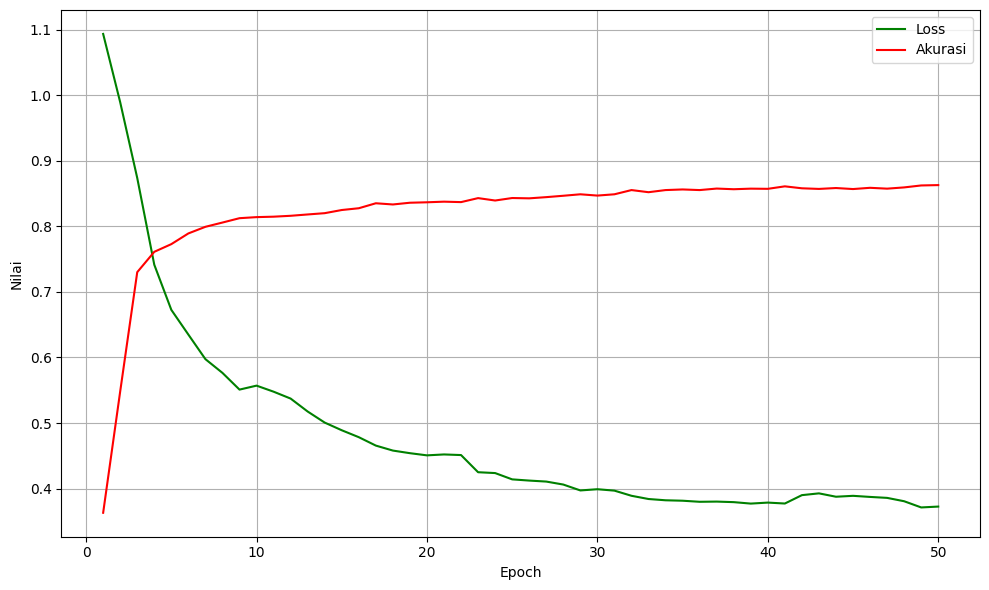

In [15]:
import matplotlib.pyplot as plt

# Extract loss and accuracy from history_rate
loss = history_latency['loss']
accuracy = history_latency['accuracy']
epochs = range(1, len(loss) + 1)

# Plot loss and accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Loss', color='green')
plt.plot(epochs, accuracy, label='Akurasi', color='red')
plt.xlabel('Epoch')
plt.ylabel('Nilai')
# plt.title('Epoch vs Loss and Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Test Accuracy: 0.8327


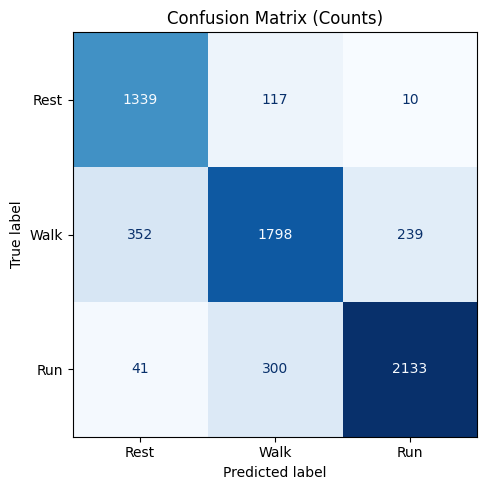

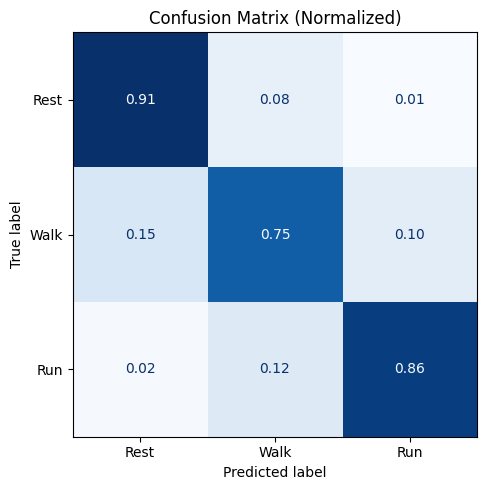

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from snntorch import spikegen, functional

modell.eval()
all_preds = []
all_labels = []
total_accu = 0.0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Latency encoding
        spk_in = spikegen.latency(X_batch,num_steps=num_steps, normalize=True)
        spk_out, _ = modell(spk_in)  # (T, B, C)

        # Temporal accuracy (scalar)
        accu = functional.accuracy_temporal(spk_out, y_batch)
        total_accu += accu.item() * X_batch.size(0)

        # === Predict class based on first spike time ===
        T, B, C = spk_out.shape
        time_steps = torch.arange(T, device=spk_out.device).view(-1, 1, 1)  # shape: (T, 1, 1)
        spike_times = torch.where(spk_out > 0, time_steps, float('inf'))    # (T, B, C)
        first_spike_times = spike_times.min(dim=0).values                   # (B, C)
        pred_labels = first_spike_times.argmin(dim=1)                       # (B,)

        all_preds.extend(pred_labels.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# === Print Accuracy ===
avg_acc = total_accu / len(test_loader.dataset)
print(f"Test Accuracy: {avg_acc:.4f}")

# === Confusion Matrix ===
classes = ['Rest', 'Walk', 'Run']  # Modify if needed

# Raw count matrix
fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(
    all_labels, all_preds,
    display_labels=classes,
    normalize=None,
    cmap=plt.cm.Blues,
    ax=ax,
    colorbar=False
)
ax.set_title("Confusion Matrix (Counts)")
plt.tight_layout()
plt.show()

# Row-normalized
fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(
    all_labels, all_preds,
    display_labels=classes,
    normalize='true',
    cmap=plt.cm.Blues,
    ax=ax,
    values_format='.2f',
    colorbar=False
)
ax.set_title("Confusion Matrix (Normalized)")
plt.tight_layout()
plt.show()

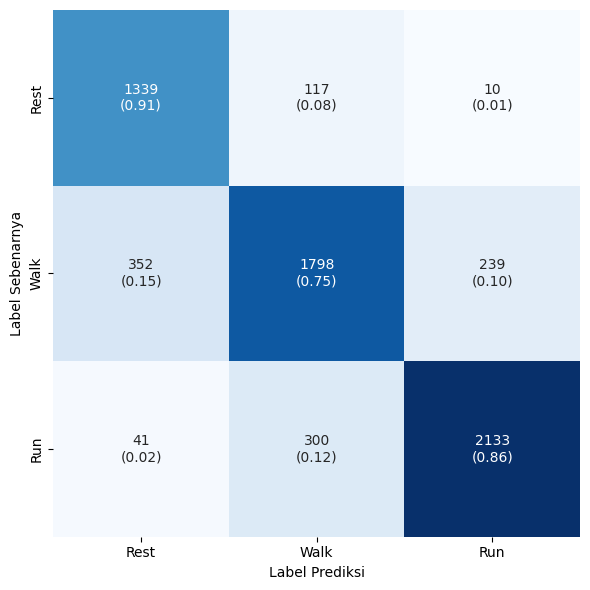

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# Combine counts and normalized values in a single string matrix
annot = np.empty_like(cm).astype(str)
n_classes = cm.shape[0]
for i in range(n_classes):
    for j in range(n_classes):
        count = cm[i, j]
        norm = cm_norm[i, j]
        annot[i, j] = f"{count}\n({norm:.2f})"

# Plot using seaborn heatmap
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=annot, fmt="", cmap="Blues", xticklabels=classes, yticklabels=classes, cbar=False, ax=ax)

ax.fondsize = 18
ax.set_xlabel("Label Prediksi")
ax.set_ylabel("Label Sebenarnya")
ax.set_title("")
plt.tight_layout()
plt.show()

In [ ]:
torch.save(modell.state_dict(), "modell_trained.pth")
print("Trained modell saved to modell_trained.pth")

In [ ]:
import matplotlib.pyplot as plt
import torch
from snntorch import spikegen

# Ensure model is in eval mode
modell.eval()

# Storage for confusion matrix and accuracy (if needed)
all_preds = []
all_labels = []
total_accu = 0.0

# Control which class examples to visualize
plotted_classes = set()
n_classes_to_plot = 3  # Set the number of classes you want to visualize

# Inference loop
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Latency encode the batch: (T, B, N)
        spk_in = spikegen.rate(X_batch, num_steps=10)

        # Forward pass through SNN: (T, B, C)
        spk_out, _ = modell(spk_in)

        # Iterate through batch samples
        for i in range(X_batch.size(0)):
            label = y_batch[i].item()

            # Plot only one sample per class
            if label not in plotted_classes:
                spk_sample = spk_in[:, i, :].cpu()  # (T, N)

                # Create raster plot with flipped axes
                fig, ax = plt.subplots(figsize=(10, 5))
                for neuron in range(spk_sample.shape[1]):
                    spike_times = torch.where(spk_sample[:, neuron] == 1)[0]
                    ax.scatter([neuron] * len(spike_times), spike_times, s=10, color='black')

                ax.set_title(f"")
                ax.set_xlabel("Index Neuron")
                ax.set_ylabel("Timestep")
                
                ax.set_xlim(0, 83)
                ax.set_ylim(-1, spk_sample.size(0))  # Optional: flip so early spikes on top
                
                plt.grid(True, linestyle='--', alpha=0.3)
                plt.tight_layout()
                plt.show()


                # Mark this class as visualized
                plotted_classes.add(label)

                # Stop once enough classes are plotted
                if len(plotted_classes) >= n_classes_to_plot:
                    break

        if len(plotted_classes) >= n_classes_to_plot:
            break


# Kuantisasi

In [20]:
def to_fixed(val, m, n):
    """
    Convert a float to a signed fixed-point integer in Qm.n format.

    Args:
      val : float      -- the value to convert
      m   : int        -- integer bits including sign
      n   : int        -- fractional bits

    Returns:
      int              -- quantized fixed-point integer
    """
    scale = 2 ** n
    max_int = 2 ** (m + n - 1) - 1
    min_int = -2 ** (m + n - 1)

    quantized = int(round(val * scale))
    return max(min(quantized, max_int), min_int)

def to_float(val, m, n):
    """
    Convert a signed fixed-point integer in Qm.n format back to float.

    Args:
      val : int        -- fixed-point integer (already sign-extended if needed)
      m   : int        -- integer bits including sign
      n   : int        -- fractional bits

    Returns:
      float
    """
    # Handle negative two's complement conversion
    max_raw = 2 ** (m + n)
    if val >= 2 ** (m + n - 1):
        val -= max_raw
    return val / float(2 ** n)


def quantize(weights, int_bits=2, frac_bits=6):
    total_bits = int_bits + frac_bits
    shape = weights.shape
    q = np.zeros_like(weights, dtype=int)

    # Use to__fixed for conversion
    for i in range(shape[0]):
        for j in range(shape[1]):
            q[i, j] = to_fixed(weights[i, j], int_bits, frac_bits)

    return q

def dequantize_q_format(q_values, int_bits=2, frac_bits=6):
    shape = q_values.shape
    float_vals = np.zeros_like(q_values, dtype=float)
    for i in range(shape[0]):
        for j in range(shape[1]):
            float_vals[i, j] = to_float(q_values[i, j], int_bits, frac_bits)
    return float_vals


def format_weights_as_binary_rows(weights_2d, bits_per_weight=8, total_width=None):

    num_weights = len(weights_2d[0])
    width = bits_per_weight * num_weights if total_width is None else total_width
    output_lines = []

    for row in weights_2d:
        # Convert each int to 2's complement binary
        bin_strs = [
            format(val & ((1 << bits_per_weight) - 1), f'0{bits_per_weight}b')
            for val in row
        ]
        full_bin = "_".join(bin_strs)
        output_lines.append(f"DataBits(0b{full_bin})")

    return output_lines


def generate_coe_file(weight_matrix, filename, int_bits=2, frac_bits=6, radix=2):
    """
    Generates a .coe file where each row merges all column weights into a single value.
    Args:
        weight_matrix: A NumPy array (or torch tensor) of weights.
        filename: Output file name.
        int_bits: Number of integer bits in fixed-point format.
        frac_bits: Number of fractional bits in fixed-point format.
        radix: Output radix: 2 (bin), 8 (oct), 16 (hex).
    """
    total_bits = int_bits + frac_bits

    # transpose to align with fpga format
    quantized = quantize(np.transpose(weight_matrix), int_bits, frac_bits)

    # Formatter function per radix
    if radix == 2:
        def formatter(x):
            return format((1 << total_bits) + x if x < 0 else x, f'0{total_bits}b')
        radix_str = "2"
    elif radix == 16:
        def formatter(x):
            return format((1 << total_bits) + x if x < 0 else x, f'0{(total_bits + 3) // 4}x')
        radix_str = "16"
    elif radix == 8:
        def formatter(x):
            return format((1 << total_bits) + x if x < 0 else x, f'0{(total_bits + 2) // 3}o')
        radix_str = "8"
    else:
        raise ValueError("Unsupported radix. Use 2, 8, or 16.")

    # Merge each row's formatted columns into one string
    merged_rows = []
    for row in quantized:
        formatted_cols = [formatter(val) for val in row]
        merged = ''.join(formatted_cols)
        merged_rows.append(merged)

    # Write COE file
    with open(filename, "w") as f:
        f.write(f"memory_initialization_radix={radix_str};\n")
        f.write("memory_initialization_vector=\n")
        f.write(",\n".join(merged_rows))
        f.write(";\n")


# Kuantisasi RATE

In [ ]:
import copy

# Backup modelr weights before quantization

modelr_backup_state = copy.deepcopy(modelr.state_dict())
print("modelr weights have been backed up.")

In [21]:
def test_modelr_with_quantization(model, test_loader, int_bits, frac_bits):
    """
    Test the model with quantized weights in the specified fixed-point format.

    Args:
        model: The PyTorch model to test.
        test_loader: DataLoader for the test dataset.
        int_bits: Number of integer bits in the fixed-point format.
        frac_bits: Number of fractional bits in the fixed-point format.

    Returns:
        accuracy: The accuracy of the model with quantized weights.
    """
    # Quantize weights
    with torch.no_grad():
        for layer in model.fc_layers:
            quantized_weights = quantize(layer.weight.detach().cpu().numpy(), int_bits, frac_bits)
            dequantized_weights = dequantize_q_format(quantized_weights, int_bits, frac_bits)
            layer.weight.copy_(torch.tensor(dequantized_weights, dtype=torch.float32).to(device))

    # Evaluate the model
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            spk_in = spikegen.rate(X_batch, num_steps=20)
            spk_out, _ = model(spk_in)
            spike_counts = spk_out.sum(dim=0)
            preds = spike_counts.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.cpu().numpy())

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    return accuracy


# Accuracy with Q2.6: 84.80%
# Accuracy with Q3.5: 84.50%
# Accuracy with Q4.4: 81.70%

# Test the model with different quantization formats
quantization_formats = [(1,7),(2, 6), (3, 5), (4, 4), (5, 3), (6, 2), (7, 1)]
for int_bits, frac_bits in quantization_formats:
    accuracy = test_modelr_with_quantization(modelr, test_loader, int_bits, frac_bits)
    print(f"Accuracy with Q{int_bits}.{frac_bits}: {accuracy * 100:.2f}%")

Accuracy with Q1.7: 84.72%
Accuracy with Q2.6: 83.66%
Accuracy with Q3.5: 81.17%
Accuracy with Q4.4: 78.09%
Accuracy with Q5.3: 64.80%
Accuracy with Q6.2: 25.58%
Accuracy with Q7.1: 23.16%


In [ ]:
# Restore original weights to modell from backup
modelr.load_state_dict(modelr_backup_state)
print("Original weights restored to modell.")

# Kuantisasi Latency

In [14]:
import copy

# Backup modelr weights before quantization

modell_backup_state = copy.deepcopy(modell.state_dict())
print("modell weights have been backed up.")

modell weights have been backed up.


In [33]:
def test_modell_with_quantization(model, test_loader, int_bits, frac_bits, num_steps=10):
    """
    Test the latency-coded SNN model with quantized weights in the specified fixed-point format.

    Args:
        model: The PyTorch model to test.
        test_loader: DataLoader for the test dataset.
        int_bits: Number of integer bits in the fixed-point format.
        frac_bits: Number of fractional bits in the fixed-point format.
        num_steps: Number of time steps for latency encoding.

    Returns:
        accuracy: The accuracy of the model with quantized weights.
    """
    # Quantize weights
    with torch.no_grad():
        for layer in model.fc_layers:
            quantized_weights = quantize(layer.weight.detach().cpu().numpy(), int_bits, frac_bits)
            dequantized_weights = dequantize_q_format(quantized_weights, int_bits, frac_bits)
            layer.weight.copy_(torch.tensor(dequantized_weights, dtype=torch.float32).to(device))

    # Evaluate the model
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            spk_in = spikegen.latency(X_batch, num_steps=num_steps, normalize=True)
            spk_out, _ = model(spk_in)
            T, B, C = spk_out.shape
            time_steps = torch.arange(T, device=spk_out.device).view(-1, 1, 1)
            spike_times = torch.where(spk_out > 0, time_steps, float('inf'))
            first_spike_times = spike_times.min(dim=0).values
            preds = first_spike_times.argmin(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.cpu().numpy())

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    return accuracy

# Latency code accuracy with Q2.6: 85.67%
# Latency code accuracy with Q3.5: 84.20%
# Latency code accuracy with Q4.4: 83.49%

# Test the latency-coded model with different quantization formats
quantization_formats = [(1,7), (2, 6), (3, 5), (4, 4), (5, 3), (6, 2), (7, 1)]
for int_bits, frac_bits in quantization_formats:
    accuracy = test_modell_with_quantization(modell, test_loader, int_bits, frac_bits, num_steps=10)
    print(f"Latency code accuracy with Q{int_bits}.{frac_bits}: {accuracy * 100:.2f}%")

Latency code accuracy with Q1.7: 83.90%
Latency code accuracy with Q2.6: 83.57%
Latency code accuracy with Q3.5: 82.75%
Latency code accuracy with Q4.4: 80.44%
Latency code accuracy with Q5.3: 23.46%
Latency code accuracy with Q6.2: 23.16%
Latency code accuracy with Q7.1: 23.16%


In [24]:
# Restore original weights to modell from backup
modell.load_state_dict(modell_backup_state)
print("Original weights restored to modell.")

Original weights restored to modell.


# Generate Spike Dataset

In [22]:
def generate_rate_spike_dataset(dataset_x, dataset_y, num_steps=20):

    X_test_tensor = torch.from_numpy(dataset_x).float()

    spike_data = spikegen.rate(X_test_tensor, num_steps=num_steps)

    spike_data_numpy = spike_data.numpy()
    y_test_numpy = y_test # y_test is already a numpy array
    
    return spike_data_numpy, y_test_numpy

def generate_latency_spike_dataset(dataset_x,dataset_y, num_steps=10):
 
    X_test_tensor = torch.from_numpy(dataset_x).float()

    spike_data = spikegen.latency(X_test_tensor, num_steps=num_steps, normalize=True)

    spike_data_numpy = spike_data.numpy()
    y_test_numpy = y_test # y_test is already a numpy array
    
    return spike_data_numpy, y_test_numpy

# Example usage:
spikes_rate, labels_rate = generate_rate_spike_dataset(X_test, y_test, num_steps=50)
#spikes_latency, labels_latency = generate_latency_spike_dataset(X_test, y_test, num_steps=10)

np.save("cpu_rate_spike_x.npy", spikes_rate)
np.save("cpu_rate_spike_y.npy", labels_rate)

# np.save("latency_spike_x.npy", spikes_latency)
# np.save("latency_spike_y.npy", labels_latency)

# Load Model RATE


In [26]:
modell.load_state_dict(torch.load("modell_trained.pth", map_location=device))
modell.eval()
print("Loaded modell weights from modell_trained.pth")

NameError: name 'modell' is not defined

In [28]:
# Extract weights from each fully connected layer in modell
layer_weights = []
for idx, layer in enumerate(modell.fc_layers):
    w = layer.weight.detach().cpu().numpy()
    layer_weights.append(w)
    print(f"Layer {idx} weights shape: {w.shape}")

# layer_weights[0], layer_weights[1], ... contain the weights for each layer

Layer 0 weights shape: (64, 83)
Layer 1 weights shape: (32, 64)
Layer 2 weights shape: (3, 32)


In [18]:
generate_coe_file(layer_weights[0], "new_lat_fc0_weights.coe", int_bits=3, frac_bits=5, radix=2)
generate_coe_file(layer_weights[1], "new_lat_fc1_weights.coe", int_bits=3, frac_bits=5, radix=2)
generate_coe_file(layer_weights[2], "new_lat_fc2_weights.coe", int_bits=3, frac_bits=5, radix=2)

In [32]:
# Extract threshold values from each LIF layer in modell
thresholds = []
for idx, lif in enumerate(modell.lif_layers):
    # Each snntorch Leaky layer has a .threshold parameter (learnable)
    thresholds.append(lif.threshold.item())
    print(f"Layer {idx} threshold: {lif.threshold.item()}")

# thresholds now contains the threshold value for each LIF layer

Layer 0 threshold: 1.0
Layer 1 threshold: 1.0
Layer 2 threshold: 1.0


In [ ]:
layer_weights

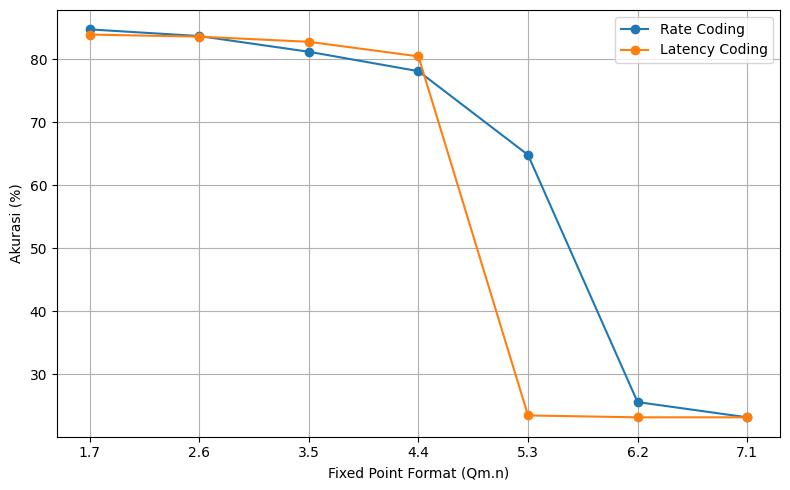

In [37]:
import matplotlib.pyplot as plt

# Data for Rate coding
x = [1.7, 2.6, 3.5, 4.4, 5.3, 6.2, 7.1]
y_rate = [84.72, 83.66, 81.17, 78.09, 64.80, 25.58, 23.16]

# Data for Latency coding
y_latency = [83.90, 83.57, 82.75, 80.44, 23.46, 23.16, 23.16]

plt.figure(figsize=(8, 5))
plt.plot(x, y_rate, marker='o', label='Rate Coding')
plt.plot(x, y_latency, marker='o', label='Latency Coding')
plt.xlabel('Fixed Point Format (Qm.n)')
plt.ylabel('Akurasi (%)')
plt.title('')
plt.grid(True)
plt.xticks(x)
plt.legend()
plt.tight_layout()
plt.show()